In [1]:
import sys
import networkx as nx
import matplotlib as plt
import numpy as np
import re
import chess
import subprocess
import timeit
import pickle
import stockfish
from stockfish import Stockfish
import chess
import chess.engine

engine = chess.engine.SimpleEngine.popen_uci("../stockfish-10-64")
stockfish = Stockfish("../stockfish-10-64")

In [2]:
def varWeighted(scores, counts):
    if (len(counts)<2):
        return None
    else:
        weightedMean = sum([a*b for a,b in zip(scores,counts)])/sum(counts)
        scoreDiffs = [(score - weightedMean)**2 for score in scores]
        V1 = sum(counts)
        V2 = sum([count**2 for count in counts])
        var = (V1/(V1**2-V2)) * sum([a*b for a,b in zip(counts,scoreDiffs)])
        return var
    
def get_score(san):
    board = chess.Board()
    for move in san:
        board.push_san(move)
    currFen = board.fen()
    score = engine.analyse(board, chess.engine.Limit(time=.05), info=chess.engine.INFO_SCORE)
    if('#' in str(score['score'])):
        if('-' in str(score['score'])):
            return -39765
        else:
            return 39765
    else:
        score = int(str(score["score"]))
    return score

def san_to_fen(san):
    board = chess.Board()
    for move in san:
        board.push_san(move)
    currFen = board.fen()
    return currFen

def get_node_sd(node):
    scores = []
    counts = []
    try:
        for neighbor in list(g.neighbors(node)):
            scores.append(nx.get_node_attributes(g, 'score')[neighbor])
            counts.append(nx.get_node_attributes(g, 'movelistCount')[neighbor][node])
        return node, np.sqrt(varWeighted(scores,counts))
    except:
        return node, None

In [3]:
game_file = "../tab-trunc.txt"

with open(game_file, "r") as file_in:
    mainlineList = []
    for line in file_in:
        mainlineList.append(line)

#extract each string of moves
stringList = []
for mainLine in mainlineList:
    stringList.append(mainLine.split())

# stringList.sort(key = len) 


In [4]:
print(len(stringList))

692287


In [5]:
#Move ['32', 'f3', 'e5', 'g4', 'Qh4#']

board = chess.Board()
board.push_san('f3') #push the move to the board
board.push_san('e5') #push the move to the board
#board.push_san('g4') #push the move to the board
#board.push_san('Qh4#') #push the move to the board
currFen = board.fen()
print(currFen)
stockfish.set_fen_position(currFen)
score = stockfish.get_evaluation()['value']
print(score)

rnbqkbnr/pppp1ppp/8/4p3/8/5P2/PPPPP1PP/RNBQKBNR w KQkq - 0 2
-101


In [6]:
cnt = 0
start = timeit.default_timer()

#initialize graph with root node
g = nx.DiGraph()
g.add_node('root', score = 0, movelist = 'root')

for s in stringList:
    whiteMove = 1
    if(cnt%5000 == 0):
        print("strings processed:", cnt, "TIME:", timeit.default_timer()-start)
    count = int(s[0])
    if(count >= 50):
        board = chess.Board()
        parentFen = 'root'
        try:
            for move in s[1:]:
                san = s[1:s.index(move)]
                board.push_san(move)
                currFen = board.fen()
                if(currFen not in g.nodes):
                    board = chess.Board(currFen)
                    if('#' not in move):
                        score = engine.analyse(board, chess.engine.Limit(time=0.05))
                        if('#' in str(score['score'])):
                            if('-' in str(score['score'])):
                                score =  -39765
                            else:
                                score =  39765
                        else:
                            score = int(str(score["score"])) * whiteMove
    #                         stockfish.set_fen_position(currFen)
    #                         score = stockfish.get_evaluation()['value']
                    else:
                        score = -39765 * whiteMove
                    g.add_node(currFen,
                               score = score,
                               count = count,
                               san = san,
                               movelistCount = {parentFen:count})
                    g.add_edge(parentFen, currFen)
                else:
                    if(parentFen in nx.get_node_attributes(g, 'movelistCount')[currFen]):
                        nx.get_node_attributes(g, 'movelistCount')[currFen][parentFen] += count #increase parent count
                    else:
                        nx.get_node_attributes(g, 'movelistCount')[currFen][parentFen] = count #add parent and count
                        g.add_edge(parentFen, currFen) #add edge from parentFen to currFen
                    g.nodes[currFen]['count'] = nx.get_node_attributes(g, 'count')[currFen] + count #increase count
    #                 whiteMove *= -1
                parentFen = currFen
        except Exception as e:
            print(e)
            print(sys.exc_info()[0])
            print("Move",s)
            stockfish.set_fen_position(currFen)
            print(stockfish.get_evaluation()['value'])
            break
        cnt+=1
    else:
        cnt+=1
            
stop = timeit.default_timer()
print('Time: ', stop - start)
print("totalNodes:",len(g))

strings processed: 0 TIME: 0.0004350600000009308
strings processed: 5000 TIME: 32.96715407200001
strings processed: 10000 TIME: 33.362832141000005
strings processed: 15000 TIME: 35.26224065500001
strings processed: 20000 TIME: 35.95697050100001
strings processed: 25000 TIME: 38.815813708
strings processed: 30000 TIME: 40.491657335000006
strings processed: 35000 TIME: 41.47703331900001
strings processed: 40000 TIME: 42.070566805999995
strings processed: 45000 TIME: 43.338069014000006
strings processed: 50000 TIME: 45.564414948
strings processed: 55000 TIME: 47.946664863
strings processed: 60000 TIME: 50.278185936999996
strings processed: 65000 TIME: 52.87165125400001
strings processed: 70000 TIME: 54.544332987
strings processed: 75000 TIME: 56.07822582800001
strings processed: 80000 TIME: 57.321704340000004
strings processed: 85000 TIME: 59.189675400999995
strings processed: 90000 TIME: 61.154075027
strings processed: 95000 TIME: 62.789976091999996
strings processed: 100000 TIME: 63.689

In [7]:
g.nodes()['rnbqkbnr/pppppppp/8/8/8/2N5/PPPPPPPP/R1BQKBNR b KQkq - 1 1']

{'score': 33, 'count': 2909, 'san': [], 'movelistCount': {'root': 2909}}

In [8]:
#nx.write_gpickle(g,"test.gpickle")

In [9]:
g = nx.read_gpickle('full690k.gpickle')

In [10]:
start = timeit.default_timer()

board = chess.Board()
board.push_san('d4') #push the move to the board
board.push_san('Nf6') #push the move to the board
currFen = board.fen()
print(currFen)
scores = []
counts = []
for neighbor in list(g.neighbors(currFen)):
    scores.append(nx.get_node_attributes(g, 'score')[neighbor])
    counts.append(nx.get_node_attributes(g, 'count')[neighbor])
    
print("sd:",np.sqrt(varWeighted(scores, counts)))

stop = timeit.default_timer()
print('Time: ', stop - start) 

rnbqkb1r/pppppppp/5n2/8/3P4/8/PPP1PPPP/RNBQKBNR w KQkq - 1 2
sd: 40.80058308142181
Time:  0.19616810899992743


In [11]:
gamesDict = {"root" : ['e4', 'c5'],
"safe" : ['e4', 'c5', 'c3'],
"risky" : ['e4', 'c5', 'd4'],
"root2" : ['e4', 'e6', 'd4', 'd5'],
"popular2.0" : ['e4', 'e6', 'd4', 'd5', 'Nc3'],
"popular2.1" : ['e4', 'e6', 'd4', 'd5', 'Nd2'],
"safe2" : ['e4', 'e6', 'd4', 'd5', 'exd5'],
"risky2" : ['e4', 'e6', 'd4', 'd5', 'e5'],
"Ruy" : ['e4', 'e5','Nf3', 'Nc6','Bb5'],
"Vienna" : ['e4' ,'e5','d4','exd4','c3']}

for key, game in gamesDict.items():
    currFen = san_to_fen(game)
    scores = []
    counts = []
    try:
        for neighbor in list(g.neighbors(currFen)):
            scores.append(nx.get_node_attributes(g, 'score')[neighbor])
            counts.append(nx.get_node_attributes(g, 'movelistCount')[neighbor][currFen])
        print('{} {} ||| SD :'.format(key, game), np.sqrt(varWeighted(scores,counts)), ", total Games:", sum(counts))
    except:
        break

    

root ['e4', 'c5'] ||| SD : 40.21762883938671 , total Games: 30613
safe ['e4', 'c5', 'c3'] ||| SD : 28.36326937009214 , total Games: 1224
risky ['e4', 'c5', 'd4'] ||| SD : 80.06188435835759 , total Games: 3702
root2 ['e4', 'e6', 'd4', 'd5'] ||| SD : 29.493432655871636 , total Games: 5868
popular2.0 ['e4', 'e6', 'd4', 'd5', 'Nc3'] ||| SD : 50.441638339302244 , total Games: 986
popular2.1 ['e4', 'e6', 'd4', 'd5', 'Nd2'] ||| SD : 66.34986448736355 , total Games: 677
safe2 ['e4', 'e6', 'd4', 'd5', 'exd5'] ||| SD : 77.32305865008192 , total Games: 639
risky2 ['e4', 'e6', 'd4', 'd5', 'e5'] ||| SD : 47.33398805676923 , total Games: 4571
Ruy ['e4', 'e5', 'Nf3', 'Nc6', 'Bb5'] ||| SD : 22.1906721266971 , total Games: 4814
Vienna ['e4', 'e5', 'd4', 'exd4', 'c3'] ||| SD : 5.861174899891382 , total Games: 753


In [12]:
sd_dict = {}
for node in g.nodes():
    n, val = get_node_sd(node)
    sd_dict.update({n: val})
#     dict.update(Iterable_Sequence of key:value)
#     sd_list.append(get_node_sd(node))

sd_dict = {key:val for key, val in sd_dict.items() if val != None}

maxSD = max(sd_dict.items(), key=lambda x : x[1])
print('Max value in Dict: ', maxSD[1])
print('Key With Max value in Dict: ', maxSD[0])

Max value in Dict:  28300.534703429195
Key With Max value in Dict:  r1bqkb1r/pppp1ppp/2n2n2/4p2Q/2B1P3/8/PPPP1PPP/RNB1K1NR w KQkq - 4 4


In [13]:
{k: v for k, v in sorted(sd_dict.items(), key=lambda item: item[1], reverse = True)}

{'r1bqkb1r/pppp1ppp/2n2n2/4p2Q/2B1P3/8/PPPP1PPP/RNB1K1NR w KQkq - 4 4': 28300.534703429195,
 'r1bqkbnr/pp1ppppp/2n5/2p4Q/2B1P3/8/PPPP1PPP/RNB1K1NR b KQkq - 3 3': 28217.09610324918,
 'rnbqk1nr/ppppppbp/6p1/8/2B1P3/5Q2/PPPP1PPP/RNB1K1NR b KQkq - 3 3': 28156.284920067133,
 'rn1qkbnr/ppp2ppp/3p4/4p3/2B1P3/5Q1P/PPPP1PP1/RNB1K2R b KQkq - 0 5': 27990.821933269483,
 'rnbqkbnr/ppppp1pp/5p2/8/3PP3/8/PPP2PPP/RNBQKBNR b KQkq - 0 2': 27982.336651895246,
 'r1bq1b1r/ppp2kpp/2n5/3np3/2B5/5Q2/PPPP1PPP/RNB1K2R b KQ - 1 7': 24076.30522729294,
 'r1bqkbnr/pppp1ppp/2n5/4p2Q/2B1P3/8/PPPP1PPP/RNB1K1NR b KQkq - 3 3': 23927.1813392801,
 'rnbqkbnr/ppp2ppp/3p4/4p2Q/2B1P3/8/PPPP1PPP/RNB1K1NR b KQkq - 1 3': 22789.888004161297,
 'r1bqkbnr/pppp1p1p/2n3p1/4p3/2B1P3/5Q2/PPPP1PPP/RNB1K1NR b KQkq - 1 4': 21873.842408513905,
 'rnbqkbnr/ppp2p1p/3p2p1/4p3/2B1P3/5Q2/PPPP1PPP/RNB1K1NR b KQkq - 1 4': 21710.162390333673,
 'rnbqk1nr/pppp1ppp/8/2b1p2Q/2B1P3/8/PPPP1PPP/RNB1K1NR b KQkq - 3 3': 21421.919561340743,
 'r1bqkbnr/pppp1pp

In [34]:
currFen =  'rnbqkbnr/p3pppp/8/1p6/2pP4/4PQ2/1P3PPP/RNB1KBNR b KQkq - 1 6'
scores = []
counts = []

for neighbor in list(g.neighbors(currFen)):
    print(neighbor, g.nodes()[neighbor])
    scores.append(nx.get_node_attributes(g, 'score')[neighbor])
    counts.append(nx.get_node_attributes(g, 'movelistCount')[neighbor][currFen])
print('SD :', np.sqrt(varWeighted(scores,counts)), ", total Games:", sum(counts))


rnb1kbnr/p3pppp/8/qp6/2pP4/4PQ2/1P3PPP/RNB1KBNR w KQkq - 2 7 {'score': 2114, 'count': 113, 'san': ['d4', 'd5', 'c4', 'dxc4', 'e3', 'b5', 'a4', 'c6', 'axb5', 'cxb5', 'Qf3'], 'movelistCount': {'rnbqkbnr/p3pppp/8/1p6/2pP4/4PQ2/1P3PPP/RNB1KBNR b KQkq - 1 6': 113}}
rn1qkbnr/pb2pppp/8/1p6/2pP4/4PQ2/1P3PPP/RNB1KBNR w KQkq - 2 7 {'score': 689, 'count': 63, 'san': ['d4', 'd5', 'c4', 'dxc4', 'e3', 'b5', 'a4', 'c6', 'axb5', 'cxb5', 'Qf3'], 'movelistCount': {'rnbqkbnr/p3pppp/8/1p6/2pP4/4PQ2/1P3PPP/RNB1KBNR b KQkq - 1 6': 63}}
rnbqkb1r/p3pppp/5n2/1p6/2pP4/4PQ2/1P3PPP/RNB1KBNR w KQkq - 2 7 {'score': 620, 'count': 54, 'san': ['d4', 'd5', 'c4', 'dxc4', 'e3', 'b5', 'a4', 'c6', 'axb5', 'cxb5', 'Qf3'], 'movelistCount': {'rnbqkbnr/p3pppp/8/1p6/2pP4/4PQ2/1P3PPP/RNB1KBNR b KQkq - 1 6': 54}}
SD : 919.2262171993208 , total Games: 230


{'depth': 15, 'seldepth': 23, 'multipv': 1, 'score': PovScore(Cp(-364), BLACK), 'nodes': 62408, 'nps': 1200153, 'tbhits': 0, 'time': 0.052}


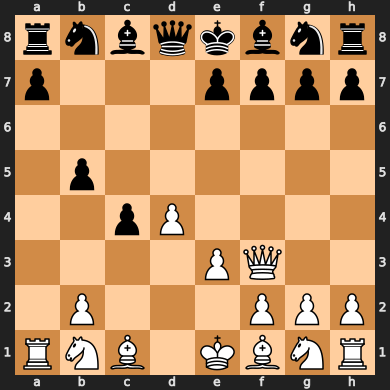

In [35]:
board = chess.Board(currFen)
print(engine.analyse(board, chess.engine.Limit(time=.05), info=chess.engine.INFO_SCORE))
board

In [36]:
board = chess.Board(currFen)
print(engine.analyse(board, chess.engine.Limit(time=.05), info=chess.engine.INFO_SCORE))
print("CURRFEN:")
print(board)
print("_"*50)
print("_"*50)
for neighbor in list(g.neighbors(currFen)):
    board = chess.Board(neighbor)
    print(engine.analyse(board, chess.engine.Limit(time=.05), info=chess.engine.INFO_SCORE))
    print(board)
    print("_"*50)

{'depth': 15, 'seldepth': 24, 'multipv': 1, 'score': PovScore(Cp(-399), BLACK), 'nodes': 69241, 'nps': 1331557, 'tbhits': 0, 'time': 0.052}
CURRFEN:
r n b q k b n r
p . . . p p p p
. . . . . . . .
. p . . . . . .
. . p P . . . .
. . . . P Q . .
. P . . . P P P
R N B . K B N R
__________________________________________________
__________________________________________________
{'depth': 17, 'seldepth': 24, 'multipv': 1, 'score': PovScore(Cp(+2298), WHITE), 'nodes': 141740, 'nps': 2779215, 'tbhits': 0, 'time': 0.051}
r n b . k b n r
p . . . p p p p
. . . . . . . .
q p . . . . . .
. . p P . . . .
. . . . P Q . .
. P . . . P P P
R N B . K B N R
__________________________________________________
{'depth': 16, 'seldepth': 20, 'multipv': 1, 'score': PovScore(Cp(+670), WHITE), 'nodes': 90344, 'nps': 1771450, 'tbhits': 0, 'time': 0.051}
r n . q k b n r
p b . . p p p p
. . . . . . . .
. p . . . . . .
. . p P . . . .
. . . . P Q . .
. P . . . P P P
R N B . K B N R
________________________________